<a href="https://colab.research.google.com/github/mavillot/FUNSD-Entity-Linking/blob/main/Paso_a_paso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from matplotlib import pyplot as plt
def mostrarImagen(img):
  plt.figure(figsize = (20,13))
  plt.imshow(img)
  plt.show()

### Dataset:

In [2]:
%%capture
!wget https://guillaumejaume.github.io/FUNSD/dataset.zip -O dataset.zip
!unzip dataset.zip

### El modelo

In [3]:
%%capture
pip install transformers

In [2]:
import torch
class Dataset():
    def __init__(self, txt):
        self.txt= txt
        self.encodings = tokenizer(txt, truncation=True, padding=True)

    def __iter__(self):
        for x in self.txt:
          yield x

    def __len__(self):
      return len(self.txt)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

In [5]:
%%capture
import shutil
!wget https://www.dropbox.com/s/u6owxoi7vniupa8/BERT.zip
shutil.unpack_archive('BERT.zip', 'BERT')

In [3]:
from transformers import BertForSequenceClassification,BertTokenizer,Trainer
tokenizer = BertTokenizer.from_pretrained('BERT')
model = BertForSequenceClassification.from_pretrained('BERT', num_labels=2)
trainer = Trainer(model)

### Candidatos según distancia. 

In [4]:
import json
from pathlib import Path
import numpy as np

In [5]:
def candidatos_v1(path):
  anot=json.loads(open(path).read())
  img=Path(path).stem+'.png'
  path_image=Path(path).parent.parent/'images'/img
  h,w,_=cv2.imread(str(path_image)).shape
  preguntas, respuestas=[],[]
  texto={}
  for bloque in anot['form']:
    if bloque['label']=='question':
      preguntas.append([bloque['id'],bloque['box']])
      texto[bloque['id']]=bloque['text']
    if bloque['label']=='answer':
      respuestas.append([bloque['id'],bloque['box']])
      texto[bloque['id']]=bloque['text']
  #Tenemos construidas las listas de preguntas y respuestas. 
  #Para cada respuesta buscamos sus candidatos.
  dic={}
  for a in respuestas:
    bbox=a[1]
    candidatos=[]
    candidatos_mas=[]
    x_a=int(bbox[0])
    x1_a=int(bbox[2])
    y_a=int(bbox[1])
    y1_a=int(bbox[3])
    pto_a=[(x_a+x1_a)/2,(y_a+y1_a)/2]
    for q in preguntas:
      bbox=q[1]
      x_q=int(bbox[0])
      x1_q=int(bbox[2])
      y_q=int(bbox[1])
      y1_q=int(bbox[3])
      pto_q=[(x_q+x1_q)/2,(y_q+y1_q)/2]
      if x_q<x1_a+0.05*w and y1_q>y_a-0.1*h and y_q<y1_a+0.01*h:
        dist=np.sqrt((x_a-x1_q)**2+(pto_a[1]-pto_q[1])**2)
        candidatos.append([q[0],dist])
      if x_q<x1_a +0.05*w and y1_q>y_a-0.6*h and y_q<y1_a+0.03*h:
        dist=np.sqrt((x_a-x1_q)**2+(pto_a[1]-pto_q[1])**2)
        candidatos_mas.append([q[0],dist])
    if candidatos!=[]:
      dic[a[0]]=candidatos
    else:
      dic[a[0]]=candidatos_mas
  return dic,texto

In [6]:
from operator import itemgetter
def orden(path):
  cand,text=candidatos_v1(path)
  for c in cand:
    aux=cand[c]
    cand[c]=[l[0] for l in sorted(aux, key=itemgetter(1))]
  return cand,text

#### Candidatos y etiquetas

In [7]:
def candidatosYetiquetas(path):
  anot=json.loads(open(path).read())
  cand,text=orden(path)
  dic_etiqueta={}
  for bloque in anot['form']:
    if bloque['label']=='answer':
      id=bloque['id']
      id_pregunta=[]
      for link in bloque['linking']:
        if link[0]==id:
          id_pregunta.append(link[1])
        else: id_pregunta.append(link[0])
      lista=cand[id]
      etiquetas=[lista[i] in id_pregunta for i in range(0,len(lista))]
      dic_etiqueta[id]=etiquetas
  return cand,dic_etiqueta,text     

## Paso a paso

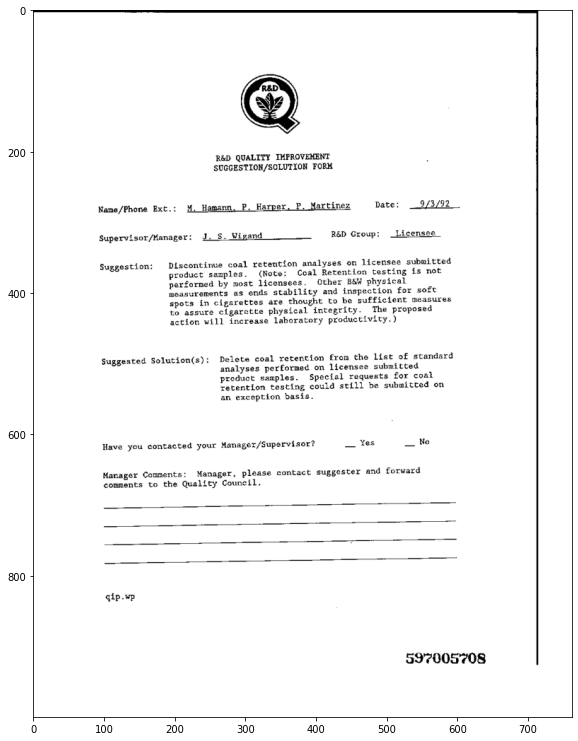

In [33]:
img=cv2.imread('dataset/training_data/images/0000971160.png')
mostrarImagen(img)

In [22]:
cv2.imwrite('image.jpg',img)

True

### Respuesta

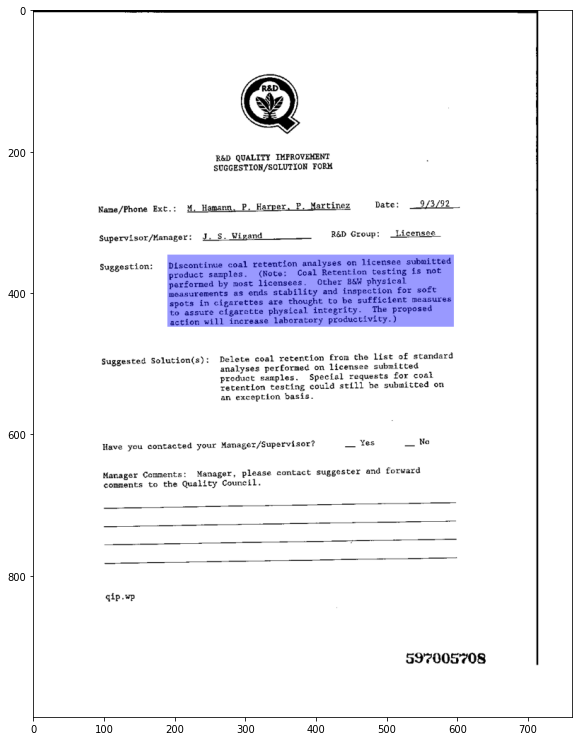

In [36]:
img=cv2.imread('dataset/training_data/images/0000971160.png')
overlay = img.copy()
anot=json.loads(open('dataset/training_data/annotations/0000971160.json').read())
for bloque in anot['form']:
  if bloque['id']==16:
    xmin,ymin,xmax,ymax=bloque['box']
    alpha = 0.4
    cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(0,0,255),-1)
    image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
mostrarImagen(image_new)

In [30]:
cv2.imwrite('image1.jpg',image_new)

True

### Candidatos

In [37]:
preguntas

[2, 15, 1, 10, 13, 3]

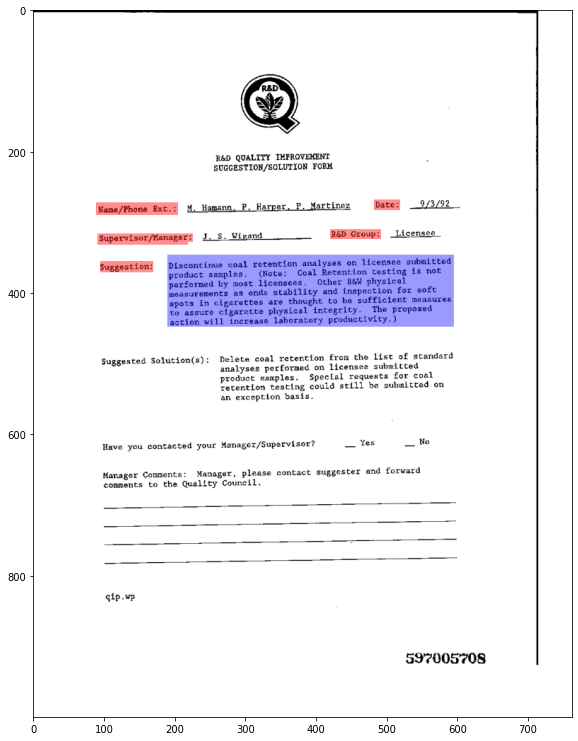

In [40]:
overlay = image_new.copy()
cand,text=orden('dataset/training_data/annotations/0000971160.json')
preguntas=cand[16]
for bloque in anot['form']:
  if bloque['id'] in preguntas:
    xmin,ymin,xmax,ymax=bloque['box']
    alpha = 0.3
    cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(255,0,0),-1)
image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)
mostrarImagen(image_new)

In [41]:
cv2.imwrite('image2.jpg',image_new)

True

### Pares pregunta-respuesta

In [14]:
pregunta_respuesta=[]
for q in preguntas:
  cadena=text[q]+text[16]
  pregunta_respuesta.append(cadena)
  print(cadena)

Suggestion:Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . )
Supervisor / ManagerDiscontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity . )
:Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spo

### Pasamos pares pregunta-respuesta por el modelo

In [15]:
dataEJ = Dataset(pregunta_respuesta)
prediction=trainer.predict(dataEJ)[0].argmax(-1)

***** Running Prediction *****
  Num examples = 6
  Batch size = 8


In [16]:
prediction

array([1, 0, 0, 0, 0, 0])

In [17]:
import pandas as pd
d = {'text': pregunta_respuesta, 'prediction': prediction}
df = pd.DataFrame(data=d)

In [18]:
df

,text,prediction
0,Suggestion:Discontinue coal retention analyses...,1
1,Supervisor / ManagerDiscontinue coal retention...,0
2,:Discontinue coal retention analyses on licens...,0
3,Name / Phone Ext. :Discontinue coal retention ...,0
4,R&D Group:Discontinue coal retention analyses ...,0
5,Date:Discontinue coal retention analyses on li...,0


## Programa Final

In [10]:
import pandas as pd
def ejemplo(id_img):
  print('FORMULARIO: ')
  img=cv2.imread('dataset/testing_data/images/'+id_img+'.png')
  mostrarImagen(img)
  overlay = img.copy()
  anot=json.loads(open('dataset/testing_data/annotations/'+id_img+'.json').read())
  cand,text=orden('dataset/testing_data/annotations/'+id_img+'.json')
  print('ID  |     TEXTO')
  print('-----------------------')
  for c in cand:
    if int(c/10) ==0:
      print(c,'  | ', text[c])
    else: print(c,' | ', text[c])
  
  print('\n')
  print('Introduce el id de la respuesta que quieres obtener su pregunta:')

  id_respuesta = 18
  print('18')
  for bloque in anot['form']:
    if bloque['id']==id_respuesta:
      xmin,ymin,xmax,ymax=bloque['box']
      alpha = 0.4
      cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(0,0,255),-1)
      image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
  print('MOSTRAMOS LA RESPUESTA SELECCIONADA: ')
  mostrarImagen(image_new)
  cv2.imwrite('image1.jpg',image_new)
  overlay = image_new.copy()
  preguntas=cand[id_respuesta]
  for bloque in anot['form']:
    if bloque['id'] in preguntas:
      xmin,ymin,xmax,ymax=bloque['box']
      alpha = 0.3
      cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(255,0,0),-1)
  image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)
  cv2.imwrite('image2.jpg',image_new)
  print('CANDIDATAS A PREGUNTA: ')
  mostrarImagen(image_new)
  pregunta_respuesta=[]
  print('\n')
  print('PARES CLAVE - VALOR: ')
  for q in preguntas:
    cadena=text[q]+ ' ' +text[id_respuesta]
    pregunta_respuesta.append(cadena)
    print(cadena)
  dataEJ = Dataset(pregunta_respuesta)
  print('\n')
  prediction=trainer.predict(dataEJ)[0].argmax(-1)
  print('\n')
  d = {'text': pregunta_respuesta, 'prediction': prediction}
  df = pd.DataFrame(data=d)
  if prediction!=[]:
    if 1 in prediction:
      encontrado=False
      m=0
      while encontrado==False:
        if prediction[m]==1:
          encontrado=True
        m+=1
      prediction[m:]=0
    else:
      prediction[0]=1
  else:
    print('no hay candidatos')
  d = {'text': pregunta_respuesta, 'prediction': prediction}
  df1 = pd.DataFrame(data=d)
  return df,df1

### Ejemplo correcto

FORMULARIO: 


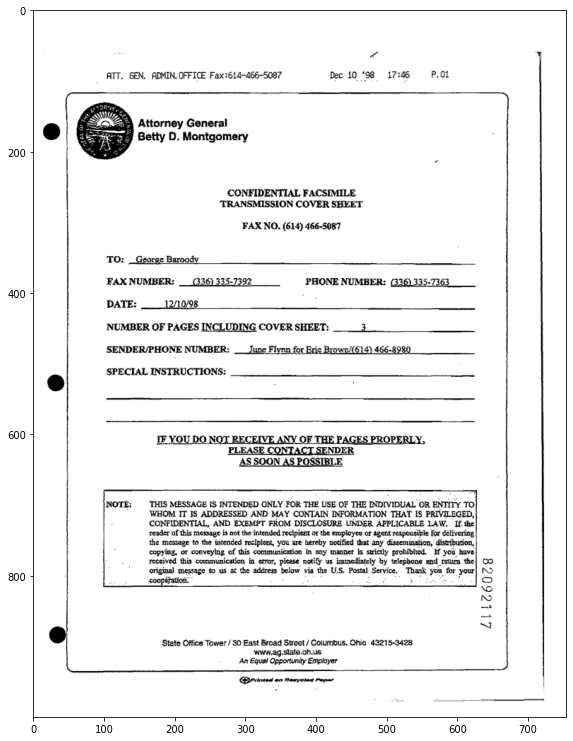

ID  |     TEXTO
-----------------------
3   |  3
7   |  614 -466 -5087
12  |  (614) 466- 5087
14  |  George Baroody
15  |  (336) 335- 7392
18  |  (336) 335- 7363
20  |  June Flynn for Eric Brown/ (614) 466- 8980
24  |  THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. If you have received this comunication in error, please notify us immediately by telephone and return the original message to us at the address below via the U. S. Postal Service. Thank you for your cooperation.
27  |  12 /10 /98


Introduce el id de la respuesta que quieres obten

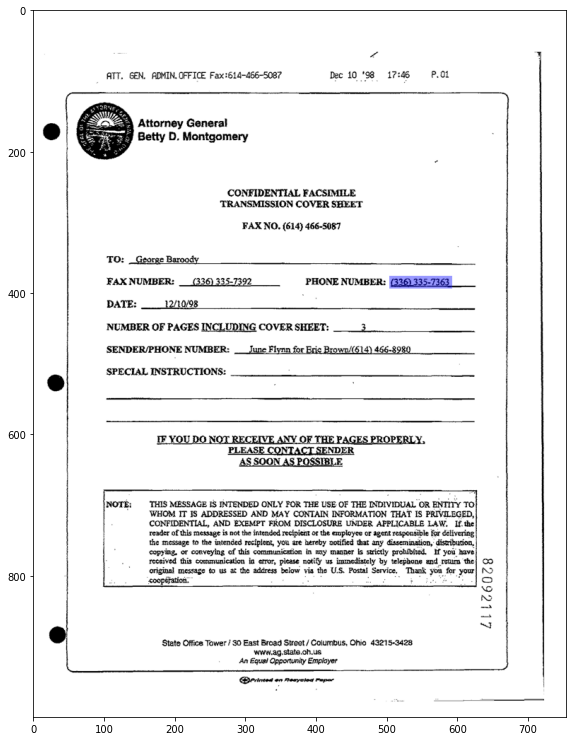

CANDIDATAS A PREGUNTA: 


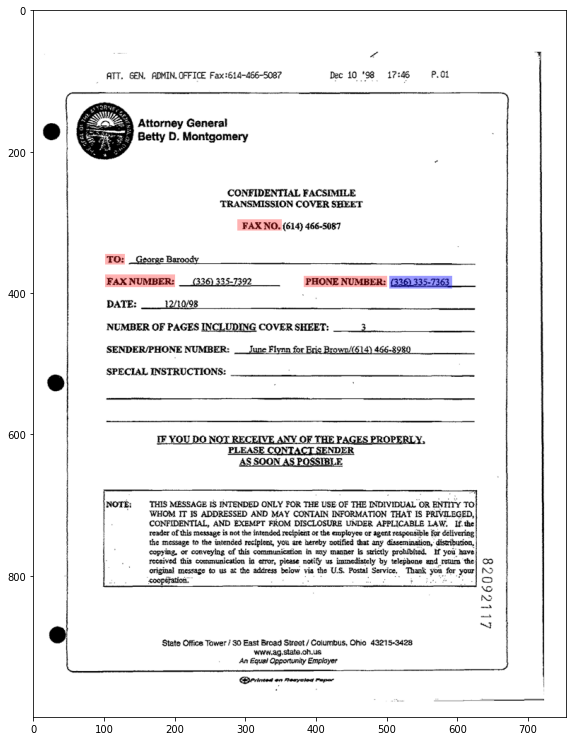

***** Running Prediction *****
  Num examples = 4
  Batch size = 8




PARES CLAVE - VALOR: 
PHONE NUMBER: (336) 335- 7363
FAX NO. (336) 335- 7363
FAX NUMBER: (336) 335- 7363
TO: (336) 335- 7363




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [11]:
pred,pred1=ejemplo('82092117')

In [14]:
pred

,text,prediction
0,PHONE NUMBER: (336) 335- 7363,1
1,FAX NO. (336) 335- 7363,1
2,FAX NUMBER: (336) 335- 7363,1
3,TO: (336) 335- 7363,0


In [15]:
pred1

,text,prediction
0,PHONE NUMBER: (336) 335- 7363,1
1,FAX NO. (336) 335- 7363,0
2,FAX NUMBER: (336) 335- 7363,0
3,TO: (336) 335- 7363,0


### Ejemplo en el que se predicen varias preguntas como candidatas

FORMULARIO: 


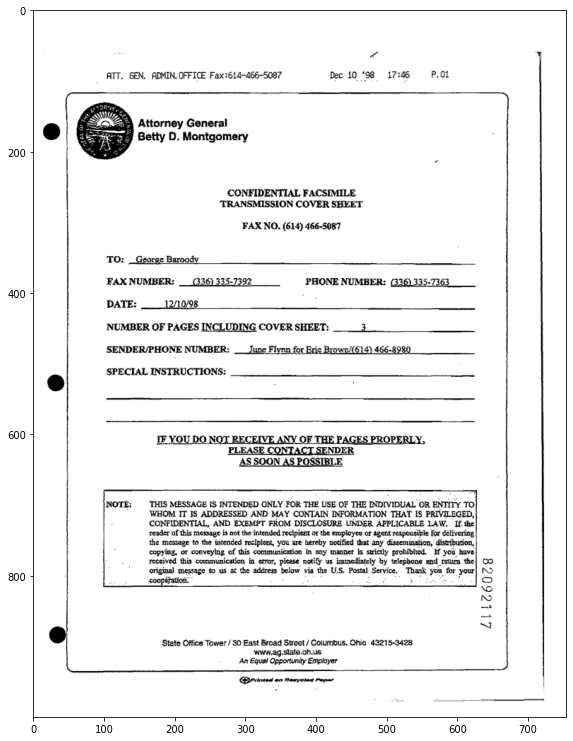

ID  |     TEXTO
-----------------------
3   |  3
7   |  614 -466 -5087
12  |  (614) 466- 5087
14  |  George Baroody
15  |  (336) 335- 7392
18  |  (336) 335- 7363
20  |  June Flynn for Eric Brown/ (614) 466- 8980
24  |  THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. If you have received this comunication in error, please notify us immediately by telephone and return the original message to us at the address below via the U. S. Postal Service. Thank you for your cooperation.
27  |  12 /10 /98


Introduce el id de la respuesta que quieres obten

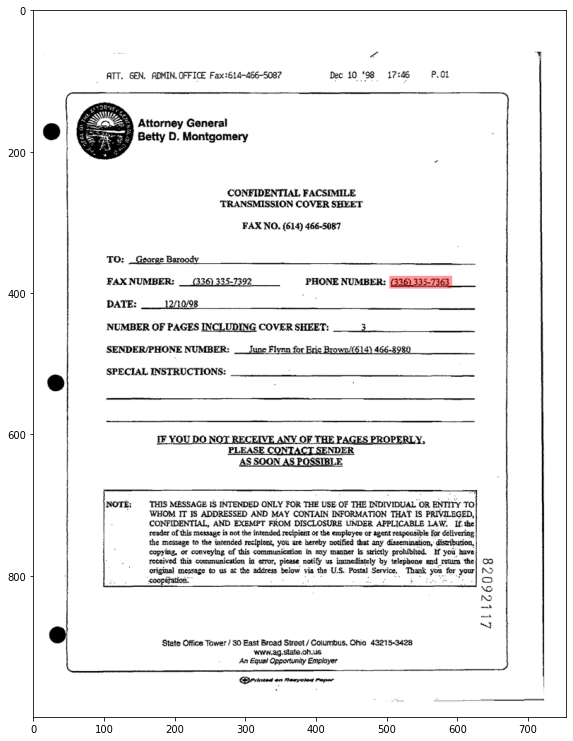

CANDIDATAS A PREGUNTA: 


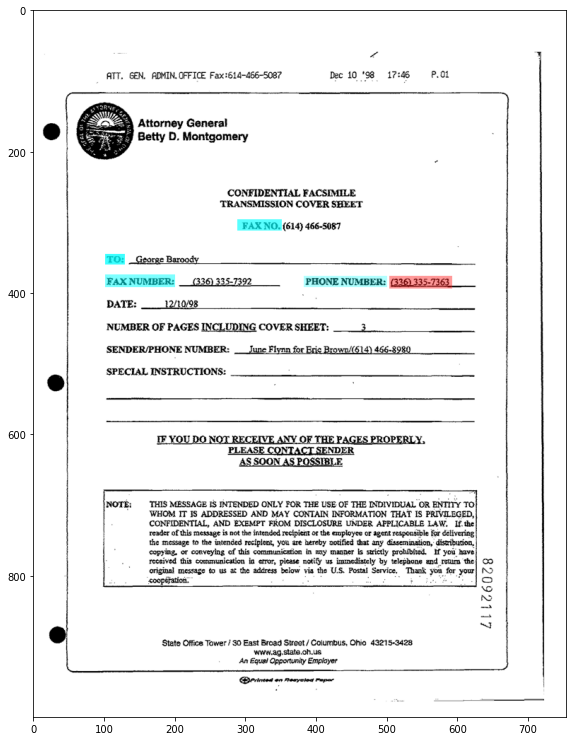

***** Running Prediction *****
  Num examples = 4
  Batch size = 8




PARES CLAVE - VALOR: 
PHONE NUMBER: (336) 335- 7363
FAX NO. (336) 335- 7363
FAX NUMBER: (336) 335- 7363
TO: (336) 335- 7363




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
pred,pred1=ejemplo('82092117')

In [ ]:
pred

,text,prediction
0,PHONE NUMBER: (336) 335- 7363,1
1,FAX NO. (336) 335- 7363,1
2,FAX NUMBER: (336) 335- 7363,1
3,TO: (336) 335- 7363,0


In [ ]:
pred1

,text,prediction
0,PHONE NUMBER: (336) 335- 7363,1
1,FAX NO. (336) 335- 7363,0
2,FAX NUMBER: (336) 335- 7363,0
3,TO: (336) 335- 7363,0


### Ejemplo en el que no se predice ningun par clave valor como correcto

FORMULARIO: 


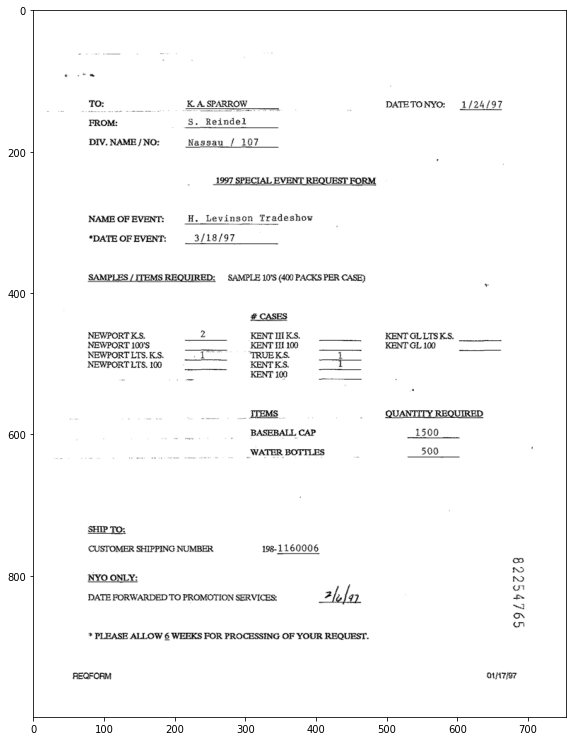

ID  |     TEXTO
-----------------------
2   |  1/24/97
3   |  2
4   |  1
5   |  1
6   |  1
8   |  zbulan
12  |  1500
13  |  500
14  |  K. A. SPARROW
16  |  S. Reindel
17  |  Nassau/ 107
22  |  3/18/97
23  |  H. Levinson Tradeshow
24  |  SAMPLE 10'S (400 PACKS PER CASE)
39  |  BASEBALL CAP
40  |  WATER BOTTLES
43  |  198- 1160006


Introduce el id de la respuesta que quieres obtener su pregunta:
12
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


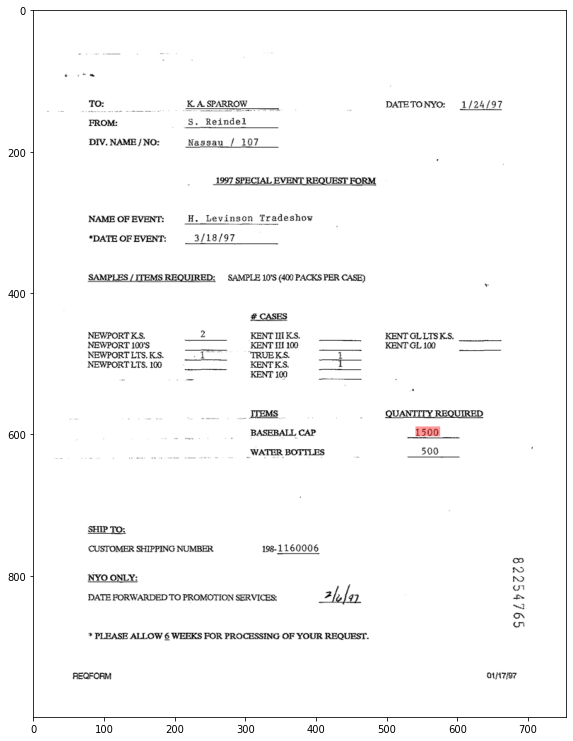

CANDIDATAS A PREGUNTA: 


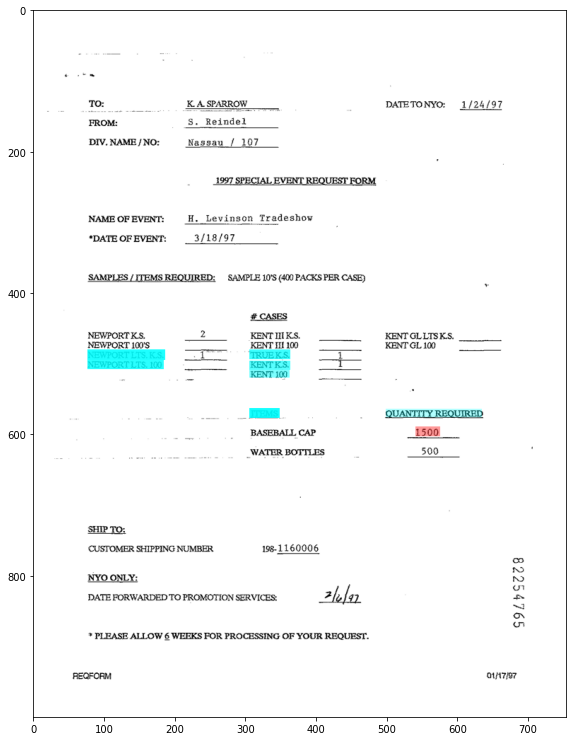

***** Running Prediction *****
  Num examples = 7
  Batch size = 8




PARES CLAVE - VALOR: 
QUANTITY REQUIRED 1500
ITEMS 1500
KENT 100 1500
KENT K. S. 1500
TRUE K. S. 1500
NEWPORT LTS. 100 1500
NEWPORT LTS K. S. 1500




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
pred,pred1=ejemplo('82254765')

In [ ]:
pred

,text,prediction
0,QUANTITY REQUIRED 1500,1
1,ITEMS 1500,1
2,KENT 100 1500,0
3,KENT K. S. 1500,0
4,TRUE K. S. 1500,0
5,NEWPORT LTS. 100 1500,0
6,NEWPORT LTS K. S. 1500,0


In [ ]:
pred1

,text,prediction
0,QUANTITY REQUIRED 1500,1
1,ITEMS 1500,0
2,KENT 100 1500,0
3,KENT K. S. 1500,0
4,TRUE K. S. 1500,0
5,NEWPORT LTS. 100 1500,0
6,NEWPORT LTS K. S. 1500,0


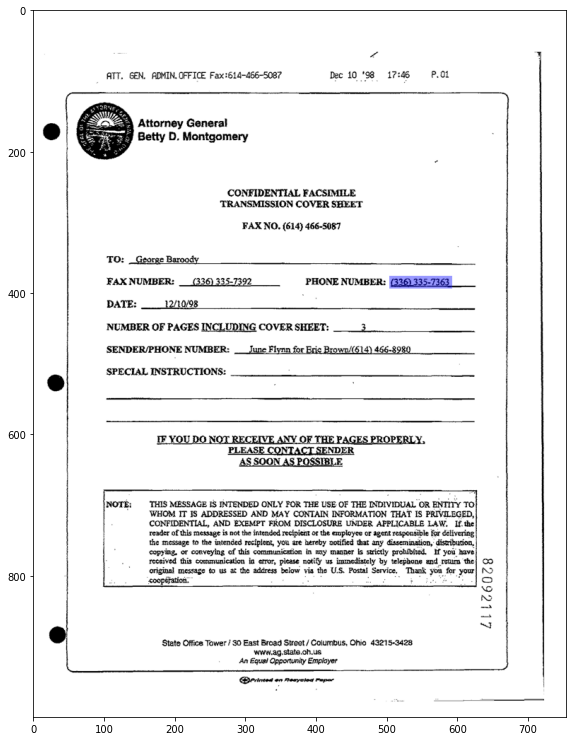

In [17]:
img=cv2.imread('dataset/testing_data/images/82092117.png')
overlay = img.copy()
anot=json.loads(open('dataset/testing_data/annotations/82092117.json').read())
for bloque in anot['form']:
  if bloque['id']==18:
    xmin,ymin,xmax,ymax=bloque['box']
    alpha = 0.4
    cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(0,0,255),-1)
    image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
mostrarImagen(image_new)

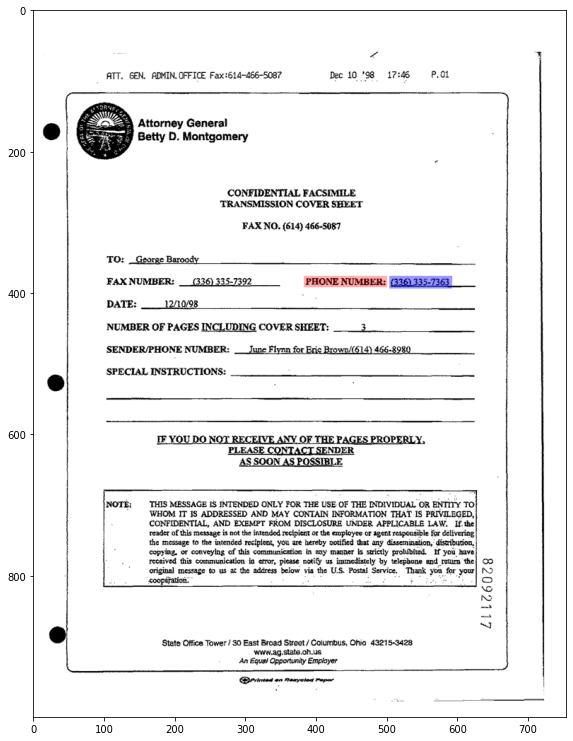

In [18]:
overlay = image_new.copy()
cand,text=orden('dataset/training_data/annotations/0000971160.json')
preguntas=cand[18]
for bloque in anot['form']:
  if bloque['id'] in preguntas[:1]:
    xmin,ymin,xmax,ymax=bloque['box']
    alpha = 0.3
    cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(255,0,0),-1)
image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)
mostrarImagen(image_new)

In [19]:
cv2.imwrite('image3.jpg',image_new)

True